In [52]:
import ee
import openeo
import numpy as np
import datetime as dt
import geemap.core as geemap
import pandas as pd
import geopandas as gpd
from geojson import Feature, FeatureCollection, Point
import csv, json
import geometryFxns
import pyap
import folium
from shapely.geometry import Polygon, MultiPolygon



In [22]:
ee.Authenticate()
ee.Initialize(project='sfeotm')

In [50]:
def get_dates (img):
  doy = ee.Date(img.get('system:time_start')).getRelative('day', 'year')
  return img.set('doy', doy)

def median_vis(img):
  # Ensure that startDoy is a number.
  doyCol = ee.ImageCollection.fromImages(img.get('doy_matches'))
  # Filter images by date range; starting with the current startDate and
  # ending 15 days later. Reduce the resulting image collection by median.
  return doyCol.reduce(ee.Reducer.median())


#Only works for africa, need to adjust region geom to make bounding box around location.
def make_visualization(wld_rgn, buffer, zoom, location):
    # Make a day-of-year sequence from 1 to 365 with a 16-day step.
  doyList = ee.List.sequence(1, 365, 16)

  # Import a MODIS NDVI collection.
  ndviCol = ee.ImageCollection('MODIS/006/MOD13A2').select('NDVI')

  # Define a map centered on San Francisco.
  Map = geemap.Map(center=[37.5010, -122.1899], zoom=zoom)

  # Create a circle by drawing a 20000 meter buffer around a point.
  roi = ee.Geometry.Point([-122.4481, 37.7599]).buffer(buffer)
  ndviCol = ndviCol.map(lambda img: img.clip(roi))


# Add the image layer to the map and display it.
  Map.add_layer(ndviCol, None, 'mosaic clipped')


 # Map.add_layer(ndviCol.first(), name = 'Raw NDVI')


  # Define a mask to clip the NDVI data by.
  #mask = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('wld_region', 'North America'))


  
  # Define the regional bounds of animation frames.
  region =ee.Geometry.Polygon(
        [[[38.231962, -123.451733],
           [36.884817, -123.451733],
           [36.884817, -121.098064],
           [38.231962, -121.098064]]]
  )

  ndviCol = ndviCol.map(get_dates)

  distinctDOY = ndviCol.filterDate('2011-01-01', '2012-01-01')



  # Define a filter that identifies which images from the complete collection
  # match the DOY from the distinct DOY collection.
  filter = ee.Filter.equals(leftField = 'doy', rightField = 'doy')


  # Define a join.
  join = ee.Join.saveAll('doy_matches')


  # Apply the join and convert the resulting FeatureCollection to an
  # ImageCollection.
  joinCol = ee.ImageCollection(join.apply(distinctDOY, ndviCol, filter))

  #Map.add_layer(joinCol.first(), name = 'Unassembeled, Reasembled')


  # Map over the list of days to build a list of image composites, this builds a ImageCollection.
  ndviCompCol = joinCol.map(median_vis)

  #Map.add_layer(ndviCompCol.first(), name = 'median_vis Display')


  # Define RGB visualization parameters.
  visParams = {
    'bands' : ['B1', 'B2'],
    'min' : 0.0,
    'max' : 9000.0, 
    'palette' : ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
      '012E01', '011D01', '011301']
  }

  # Create RGB visualization images for use as animation frames.
  rgbVis = ndviCompCol.map(lambda img : img.visualize( min = 0.0, max = 9000.0, palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
      '012E01', '011D01', '011301']).clip(roi))

  Map.add_layer(rgbVis.first(), name = 'rgb NDVI Display')
  # Define GIF visualization parameters.
  gifParams = {
    'region': roi,
    'dimensions': 600,
    'crs': 'EPSG:3857',
    'framesPerSecond': 10
  }

  display(Map)


  # Print the GIF URL to the console.
  return rgbVis.getVideoThumbURL(gifParams)



make_visualization('USA', buffer = 900000, zoom = 5, location = [37.5010, -122.1899])

Map(center=[37.501, -122.1899], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

'https://earthengine.googleapis.com/v1/projects/sfeotm/videoThumbnails/7284c74f2105e6d44718c51a7c4d9e6a-c057fa3a1fee119d50674bf42f3109cc:getPixels'

In [294]:
import shapely


#### Take in df(csv) with geojson elements as string(in column), convert this to a polygon object and output geojson or geopandas ####

def Str_element_to_geometry(df, column):
    column = df[column]
    polygon_counter = 0
    MultiPolygon_counter = 0
    new_column = []
    for item in column:
        items = item.split('":')                                                                                                          # Split each element by a colon
        item_class = items[0][2:]                                                                                                         # For my dataset, this is coordinates
        geom_list = [eval(x.strip()) for x in items[1][1:(len(items[1])-7)].split('],[')]                                                 # List of listsof lists... of points, trim the end as it contains the word "type"
        geom_type = items[2][2:(len(items[2])-2)]                                                                                         # third element of list is the geometry type and you need to trim it a bit

        if geom_type == "Polygon":                                                                                                        # If clauses now to create the geometry
            polygon_counter += 1
            geom_array = np.array(geom_list, dtype = object)
            geom = shapely.Polygon(geom_array[0][0])
        if geom_type == "MultiPolygon":
            MultiPolygon_counter += 1
            geom = shapely.MultiPolygon(geom_list[0])
        new_column.append(geom)
    gdf = df                                                                                                                              # Creating the GeoDataFrame
    gdf['Geometry'] = new_column
    gdf = gpd.GeoDataFrame(gdf)
    return(gdf)


  Obtaining dependency information for pyap from https://files.pythonhosted.org/packages/53/b2/f0f962a5385d54cd91c153df93932b4996b793f1a2145807823d7f71328d/pyap-0.3.1-py2.py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [7]:
from geometryFxns import create_office_geodataframe


xompass_gdf = create_office_geodataframe("https://www.compass.com/about/offices/")


n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n


In [44]:
## To impliment into geometryFxns.py to ensure more addresses are geocoded
print("number of unreadable addresses is:", len(xompass_gdf[xompass_gdf['geometry'] == None]))


for index, item in enumerate(xompass_gdf['geometry']):
    if item == None:
        office_location = xompass_gdf['office_location'][index]
        address = pyap.parse(office_location, country='US')
        if len(address) > 0:
            address_dict = address[0].as_dict()
            codeable_address = str(address_dict['street_number'] + ' ' + address_dict['street_name'] + ' ' + address_dict['street_type'] + ' ' + address_dict['city'] + ', ' + address_dict['region1'] + ' ' + address_dict['postal_code'])
            print(codeable_address)
            xompass_gdf.loc[index, 'geometry'] = geometryFxns.geocode_address(codeable_address)


        


number of unreadable addresses is: 244
68-70 The Crossing Chappaqua, NY 10514
5 Essex Square Essex, CT 06426
1 Sasco Hill Road Fairfield, CT 06824
89 Whitfield Street Guilford, CT 06437
724 Boston Post Road Madison, CT 06443
69 Broad St First Floor Stamford, CT 06901
2424 Main Street Bridgehampton, NY 11932
63 Main Street Hampton, NY 11937
n
182 Seventh Street Garden City, NY 11530
n
41 The Plaza Locust Valley, NY 11560
485 Underhill Blvd Syosset, NY 11791
222 Haddon Avenue Haddon Township, NJ 08108
703 Stokes Road Medford, NJ 08055
1200 Morris Turnpike Short Hills, NJ 07078
126 Newbury Street Boston, MA 02116
1330 Boylston Street Chestnut Hill, MA 02467
18 Shipyard Dr. Hingham, MA 02043
161 Linden Street Wellesley, MA 02482
1550 Falmouth Road Centerville, MA 02632
681 Falmouth Road Mashpee, MA 02649
32 Main Street Orleans, MA 02653
n
29 Meetinghouse Ln Little Compton, RI 02837
369 S Main St Providence, RI 02903
235 Main Street Wakefield, RI 02879
210 Upper St. Clair, PA 15241
6021 Wal

In [94]:
print('number of unreadable addresses is:', len(xompass_gdf[xompass_gdf['geometry'] == None]))


def create_map_with_geoms(gdf):
    
    #df = create_office_geodataframe(url)
    # Create a map centered on the mean of all points
    no_missing_gdf = gdf[gdf['geometry'] != None]
    points = [[point.xy[1][0], point.xy[0][0]] for point in no_missing_gdf['geometry']]
    center_lat = sum(points[0][0] for point in points) / len(no_missing_gdf)
    center_lon = sum(points[0][1] for point in points) / len(no_missing_gdf)
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=4)
    
    # Add each geometry to the map
    for i in range(len(no_missing_gdf)):
        row = no_missing_gdf.iloc[i]
        geom = row['geometry']
        folium.Marker(
            points[i],

            popup=f"{row['office_title']}<br>{row['office_location']}<br>{row['office_phone_number']}"
        ).add_to(m)
    
    filepath = 'map.html'
    m.save(filepath)
    return 

create_map_with_geoms(xompass_gdf)

#xompass_gdf.to_file('compass_geodata.csv', driver = "CSV", geometry = "AS_WKT")
# import webbrowser
# webbrowser.open('map.html')


number of unreadable addresses is: 105


In [5]:

print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [5]:
#ee date to python date
ee_date = ee.Date('2020-02-12')
py_date = dt.datetime.utcfromtimestamp(ee_date.getInfo()['value']/1000)
py_date

#python date to ee date
py_date = dt.datetime.utcnow()
ee_date = ee.Date(py_date)
print(ee_date)

ee.Date({
  "functionInvocationValue": {
    "functionName": "Date",
    "arguments": {
      "value": {
        "constantValue": 1724781664854
      }
    }
  }
})


C:\Users\Tyler Marino\AppData\Local\Temp\ipykernel_22612\3424296761.py:3: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  py_date = dt.datetime.utcfromtimestamp(ee_date.getInfo()['value']/1000)
C:\Users\Tyler Marino\AppData\Local\Temp\ipykernel_22612\3424296761.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  py_date = dt.datetime.utcnow()


Note: you may need to restart the kernel to use updated packages.


In [ ]:
###How to export images

# task = ee.batch.Export.image.toDrive(image=my_image,  # an ee.Image object.
#                                      region=my_geometry,  # an ee.Geometry object.
#                                      description='mock_export',
#                                      folder='gdrive_folder',
#                                      fileNamePrefix='mock_export',
#                                      scale=1000,
#                                      crs='EPSG:4326')
# task.start()
# task.status()



In [95]:
### Get geometries

States_geoms = pd.read_csv("us-state-boundaries.csv", delimiter=';')
County_geoms = pd.read_csv("us-county-boundaries.csv", delimiter= ';')




County_geoms.tail()



# California_coordinates_str = list(States_geoms[States_geoms['name'] == "California"]["St Asgeojson"])[0][15:(57661-9)]
# #print(California_coordinates_str)
# sublists = [eval(x.strip()) for x in California_coordinates_str[1:-1].split('],[')]
# sublists = sublists
# #California_coordinates = ee.featurecollection(sublists)
# #California_coordinates\


FileNotFoundError: [Errno 2] No such file or directory: 'us-state-boundaries.csv'

In [290]:
geometryFxns.Str_element_to_geometry(County_geoms, "Geo Shape")

TypeError: 'float' object is not iterable

coordinates
[[[[-92.8870669998142, 45.644148000243], [-92.882504000142, 45.6594709999592], [-92.8789320003316, 45.6656060003126], [-92.8754879996695, 45.6890140000094], [-92.8701450000226, 45.6967569997031], [-92.8717750002922, 45.6997740001271], [-92.8688620000827, 45.7119929997078], [-92.8691929996205, 45.7175679997961], [-92.8625979999958, 45.7222409998213], [-92.8509329996374, 45.7238309999597], [-92.8488510003546, 45.7287509999304], [-92.8289810001934, 45.7337140001747], [-92.8165590003249, 45.7420369999782], [-92.8098369995803, 45.7441720001411], [-92.8049419996471, 45.7479159998752], [-92.8026300002104, 45.751887999756], [-92.7846170000996, 45.7641989997565], [-92.7764819997187, 45.7900039998289], [-92.7720649996364, 45.7952299998324], [-92.761832999904, 45.8012580000347], [-92.7578150000299, 45.8065739999136], [-92.7579470002744, 45.8112159999288], [-92.7656809998989, 45.8272519999053], [-92.7651460001466, 45.8301830001258], [-92.7594579998199, 45.835341000248], [-92.7510839999

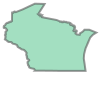

In [148]:
items = list(States_geoms["St Asgeojson"])[len(States_geoms)-1].split('":')
print(items[0][2:])
print([eval(x.strip()) for x in items[1][1:(len(items[1])-7)].split('],[')])
print(items[2][2:(len(items[2])-2)])

geom_array = np.array([eval(x.strip()) for x in items[1][1:(len(items[1])-7)].split('],[')], dtype=object)
print(geom_array[0][0])
shapely.Polygon(geom_array[0][0])

In [295]:


Stastes_gdf = Str_element_to_geometry(States_geoms, "St Asgeojson")
county_gdf = Str_element_to_geometry(County_geoms, "Geo Shape")
# for index, item in enumerate(multipolygon_problem[0].tolist()):
#     list = item
#     for i, itemm in enumerate(list):
#         array = np.array(itemm)
        
#         #to_fill[i] = array
len(county_gdf)

TypeError: 'float' object is not iterable

In [57]:
states_border = ee.FeatureCollection("WM/geoLab/geoBoundaries/600/ADM1")
voting_boundries = ee.FeatureCollection("WM/geoLab/geoBoundaries/600/ADM2")
voting_boundries.filterBounds(ee.Geometry(sublists))

EEException: Invalid GeoJSON geometry.

In [16]:
map = geemap.Map()
styleParams = {
  "fillColor": 'b5ffb4',
  "color": '00909F',
  "width": 1.0,
}

dataset = states_border

map.addLayer(dataset, {}, 'States Boundaries')
map.addLayer(voting_boundries, {}, 'Municipalities Bountries')
map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [44]:
#Loading image

# Load a Landsat image.
img = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_034033_20000913')
print(img.getInfo())

{'type': 'Image', 'bands': [{'id': 'SR_B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'SR_B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'SR_B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'SR_B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'SR_B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30

In [45]:
#Displaying a Map

# Initialize a map object.
m = geemap.Map()

# Add the image to the map.
m.add_layer(img, None, 'Random image')

# Display the map (you can call the object directly if it is the final line).
display(m)

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

  Obtaining dependency information for geemap from https://files.pythonhosted.org/packages/17/3c/e4f4e57317b4eef31804a836c3d4f67ca5345f2a117b97f0e92049043b5f/geemap-0.34.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for bqplot from https://files.pythonhosted.org/packages/ad/f5/717a355a47e8ba28ff9fcbe63d3014b55a8d20f3983582205085e85e2869/bqplot-0.12.43-py2.py3-none-any.whl.metadata
  Obtaining dependency information for colour from https://files.pythonhosted.org/packages/74/46/e81907704ab203206769dee1385dc77e1407576ff8f50a0681d0a6b541be/colour-0.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for eerepr>=0.0.4 from https://files.pythonhosted.org/packages/0b/71/5a5e36ad755e3e3081b43acf9ac2a50d1f6f88211aa278bb80114d0b6cd6/eerepr-0.0.4-py3-none-any.whl.metadata
  Obtaining dependency information for geocoder from https://files.pythonhosted.org/packages/4f/6b/13166c909ad2f2d76b929a4227c952630ebaf0d729f6317eb09cbceccbab/geocoder-1.38.1-py2.py3-none-a

In [53]:


# Load a Landsat 8 collection for a single path-row, 2021 images only.
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterDate('2021', '2022').filter(ee.Filter.eq('WRS_PATH', 44)).filter(ee.Filter.eq('WRS_ROW', 34))
collection.length()
#This function uses a conditional statement to return the image if
# the solar elevation > 40 degrees. Otherwise it returns a "zero image".
def conditional(image):
  return ee.Algorithms.If(ee.Number(image.get('SUN_ELEVATION')).gt(40),
                          image,
                          ee.Image(0))


# Map the function over the collection and print the result. Expand the
# collection and note that 7 of the 22 images are now "zero images'.
print('Expand this to see the result', collection.map(conditional))
newer_collection = collection.map(conditional)


m.add_layer(newer_collection, None, 'collection Augmented')
display(m)

AttributeError: 'ImageCollection' object has no attribute 'length'